# Accuracy of the outlier algorithm

This notebook tests the accuracy of the two algorithms used for outlier detection and removal:
- DBSCAN 
- Kmeans

## Algorithm

In [1]:
# import the necessary packages
# Base packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Pyleoclim for integration
import pyleoclim as pyleo

# The magic 
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [29]:
def calculate_distances(ys, n_neighbors=None):
    
    ys=pyleo.utils.tsutils.standardize(ys)[0]
    ys=np.array(ys)
    
    if n_neighbors is None:
        # Lowest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        if min_eps<=0:
            min_eps=0.01
    
        # Highest number of nearest neighbors
        neigh = NearestNeighbors(n_neighbors=len(ys)-1)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        max_eps = np.max(distances)
    
    else:
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        nbrs = neigh.fit(ys.reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ys.reshape(-1, 1))
        min_eps = np.min(distances)
        max_eps = np.max(distances)
    
    return min_eps, max_eps

def detect_outliers_DBSCAN(ys,eps=None, min_samples=None, n_neighbors=None, metric='euclidean'):
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    if eps is None:
        min_eps,max_eps = calculate_distances(ys, n_neighbors=n_neighbors)       
        eps_list = np.linspace(min_eps,max_eps,50)
    elif type(eps) is list:
        eps_list=eps
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        eps_list=[eps]
    
    if min_samples is None:
        min_samples_list = np.linspace(2,len(ys)/4,50,dtype='int')
    elif type(min_samples) is list:
        min_samples_list = min_samples
    else:
        print("You have tried to pass a float or integer, coercing to a list")
        min_samples_list=list(min_samples)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    
    nbr_clusters=[]
    sil_score =[]
    eps_matrix=[]
    min_sample_matrix=[]
    idx_out = []

    for eps_item in eps_list:
        for min_samples_item in min_samples_list:
            eps_matrix.append(eps_item)
            min_sample_matrix.append(min_samples_item)
            m = DBSCAN(eps=eps_item, min_samples=min_samples_item)
            m.fit(ys.reshape(-1,1))
            nbr_clusters.append(len(np.unique(m.labels_)))
            try:
                sil_score.append(silhouette_score(ys.reshape(-1,1), m.labels_))
            except:
                sil_score.append(np.nan)
            idx_out.append(np.where(m.labels_==-1)[0])
            
    res = pd.DataFrame({'eps':eps_matrix,'min_samples':min_sample_matrix,'number of clusters':nbr_clusters,'silhouette score':sil_score,'outlier indices':idx_out})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]
    
    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def detect_outliers_kmeans(ys, nbr_cluster=None, max_cluster = 10, threshold=3):
    
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    # Grab the clusters and associated centers
    if nbr_cluster is not None:
        if type(nbr_cluster) == list:
            range_n_clusters = nbr_cluster
        else:
            range_n_clusters = [nbr_cluster]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1))
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def remove_outliers(ts,ys,indices):
    ys=np.delete(ys,indices)
    ts=np.delete(ts,indices)
    return ts,ys    

In [3]:
class Series(pyleo.Series):
    def outliers(self,method='kmeans',remove=True, settings=None,fig_outliers=True,figsize=[10,4],plot_kwargs=None,savefig_settings=None):
        
        if method not in ['kmeans','DBSCAN']:
            raise ValueError('method should either be "kmeans" or "DBSCAN"')
        
        # run the algorithm
        settings = {} if settings is None else settings.copy()
        savefig_settings = {} if savefig_settings is None else savefig_settings.copy()
        spec_func={
            'kmeans':detect_outliers_kmeans,
            'DBSCAN':detect_outliers_DBSCAN}
        args = {}
        args['kmeans'] = {}
        args['DBSCAN'] = {}
        args[method].update(settings)
        
        indices, res = spec_func[method](self.value,**args[method])
        
        new=self.copy()        
        if remove==True:
            ts,ys=remove_outliers(self.time,self.value,indices)
            new.value=ys
            new.time=ts
        
        if fig_outliers == True:
            fig,ax = plt.subplots(figsize=figsize)
            pyleo.utils.plotting.plot_scatter_xy(self.time,self.value,self.time[indices],self.value[indices],xlabel=self.time_unit,ylabel=self.value_unit,plot_kwargs=plot_kwargs,ax=ax)
            if 'path' in savefig_settings:
                pyleo.utils.plotting.savefig(fig,settings=savefig_settings)
        
        return new  

## Tests on signals with trends - pseudo-series

The types of trend to be considered:
- Linear
- Polynomial
- Sinusoidal (1 sin) - the automated detrending might fail. Use for testing the effect of bad detrendind
- S-shape

### Create various signals

In [4]:
def add_trend(time, value, trend_type='linear'):
    
    if trend_type=='linear':
        
        slope = 0.01
        intercept = -1
        ys = time*slope+intercept
    
    elif trend_type=='polynomial':
        slope = 1e-5
        intercept = -1
        ys = slope*time**2+intercept
    
    elif trend_type=='sinusoidal':
        freqs=1/1500
        ys= 2*np.std(value)*np.cos(2*np.pi*freqs*time)
        
    elif trend_type =='s-shape':
        cut=[666,1332]
        value_offset_1 = np.mean(value[:cut[0]])+8
        value_offset_2 = np.mean(value[cut[1]:])
        slope = (value_offset_2-value_offset_1)/(time[cut[1]]-time[cut[0]])
        intercept = value_offset_2-(slope*time[cut[1]])
        
        ys=np.zeros(len(time))
        ys[0:cut[0]] = value_offset_1
        ys[cut[0]:cut[1]] = time[cut[0]:cut[1]]*slope+intercept
        ys[cut[1]:] = value_offset_2
        
    return ys

def create_signal(trend_type='linear'):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)

    # Add colored noise

    t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
    noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
    # Add outliers
    out_indices = [350, 1482, 1982, 1156, 750, 982]
    outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
    outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
    vals = np.arange(outliers_start,outliers_end,0.1)
    outlier_values=np.concatenate((vals,-vals))
    out_vals=outlier_values[[2,26,40,56,69,78]]
    time_out = time[out_indices]
    
    signal_out = np.copy(noisy_sig)
    for idx,item in enumerate(out_indices):
        signal_out[item] = out_vals[idx]
    
    ### add trend
    signal_trend = signal_out+add_trend(time,signal_out,trend_type=trend_type)
    
    return time,signal_trend,time_out,out_vals,out_indices

Let's plot the various signals:
- Linear

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

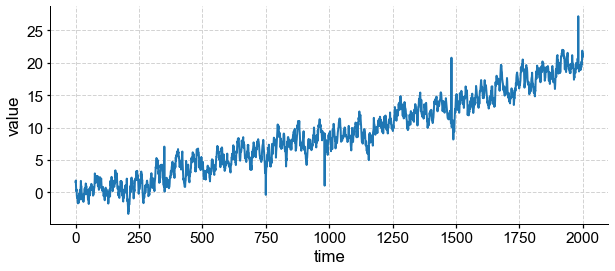

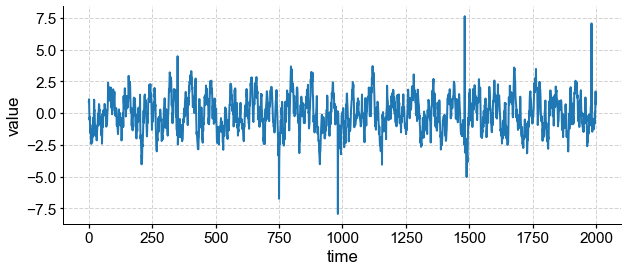

In [5]:
time,value,time_out,value_out,out_indices = create_signal(trend_type='linear')
ts_linear = Series(time=time,value=value)
ts_linear.plot()
ts_linear.detrend().plot()

- Polynomial

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

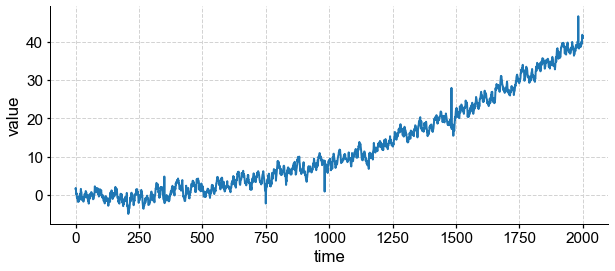

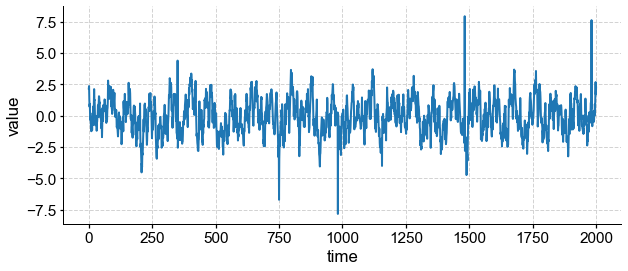

In [6]:
time,value,time_out,value_out,out_indices = create_signal(trend_type='polynomial')
ts_poly = Series(time=time,value=value)
ts_poly.plot()
ts_poly.detrend().plot()

- sinusoidal

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

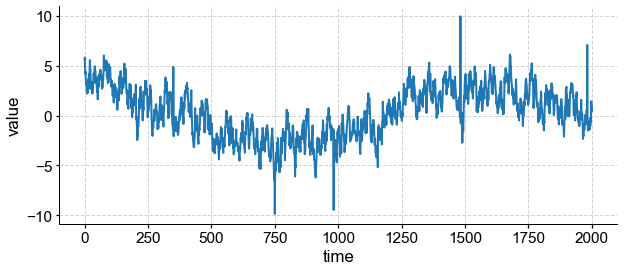

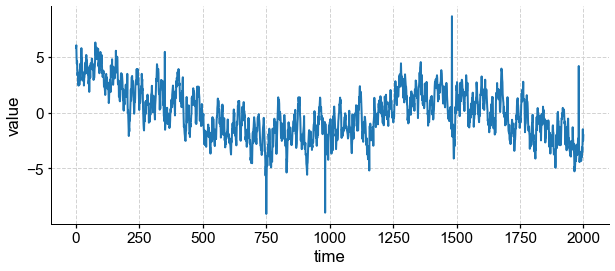

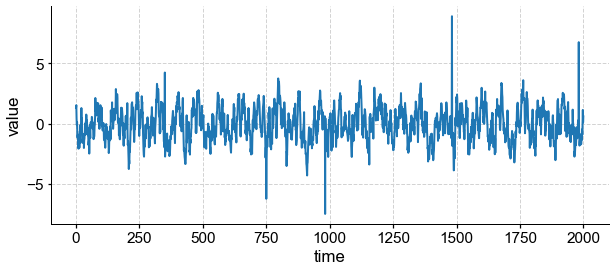

In [7]:
time,value,time_out,value_out,out_indices = create_signal(trend_type='sinusoidal')
ts_sin = Series(time=time,value=value)
ts_sin.plot()
ts_sin.detrend().plot()
ts_sin.detrend(n=4).plot()

- s-shaped

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='value'>)

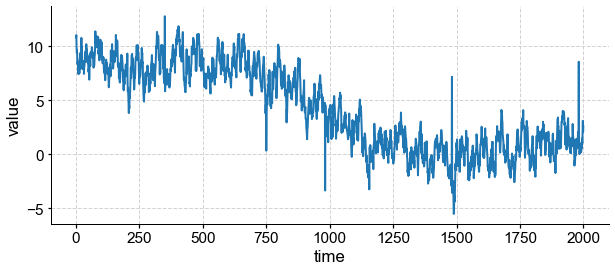

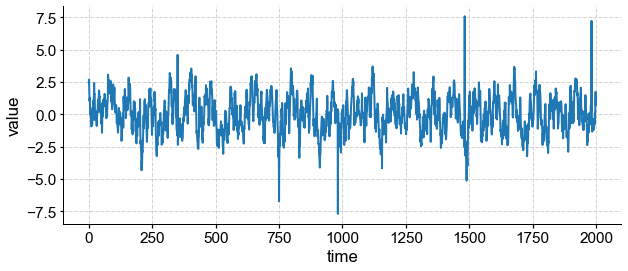

In [8]:
time,value,time_out,value_out,out_indices = create_signal(trend_type='s-shape')
ts_sshape = Series(time=time,value=value)
ts_sshape.plot()
ts_sshape.detrend().plot()

### Outlier removal tests

**NOTE**: This notebook was created before adjusting for outliers in the number of clusters calculate for DBSCAN. Therefore, the "number of clusters" is clusters + outliers 

Default parameters: 

In [33]:
method=['DBSCAN', 'kmeans']
out_indices = [350, 1482, 1982, 1156, 750, 982]
signals = ['linear','polynomial','sinusoidal_detrend','sinusoidal_trend','s-shape']

method_list=[]
out_truth=[]
trend_list = []
out_inferred = []
correct = [] 
false_positive =[]
missed =[]

In [34]:
%%time
for m in method:
    for signal in signals:
        method_list.append(m)
        out_truth.append(out_indices)
        trend_list.append(signal)
        if signal == 'sinusoidal_detrend':
            time,value,time_out,value_out,out_indices = create_signal(trend_type='sinusoidal')
        elif signal == 'sinusoidal_trend':
            time,value,time_out,value_out,out_indices = create_signal(trend_type='sinusoidal')
        else: 
            time,value,time_out,value_out,out_indices = create_signal(trend_type=signal)
        ts=Series(time=time,value=value)
        if signal == 'sinusoidal_detrend':
            ts_d = ts.detrend(n=4)
        else:
            ts_d = ts.detrend()
        if m == 'DBSCAN':
            idx, res = detect_outliers_DBSCAN(ts_d.value)
        else:
            idx, res = detect_outliers_kmeans(ts_d.value)
        out_inferred.append(idx)
        correct.append(len(set(list(idx)).intersection(list(out_indices))))
        false_positive.append(len(idx)-len(set(list(idx)).intersection(list(out_indices))))
        missed.append(len(list(out_indices))-len(set(list(idx)).intersection(list(out_indices))))

Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 8min 8s, sys: 1min 2s, total: 9min 10s
Wall time: 8min 36s


Create a dataframe to display:

In [35]:
df = pd.DataFrame({'Method': method_list,
                   'Type of trends': trend_list,
                   'Indices of added outliers': out_truth,
                   'Indices of identified outliers': out_inferred,
                   'Number of Correctly Identified outliers': correct,
                   'Number of false positive': false_positive,
                   'Number of false negative': missed
                  })

df

,Method,Type of trends,Indices of added outliers,Indices of identified outliers,Number of Correctly Identified outliers,Number of false positive,Number of false negative
0,DBSCAN,linear,"[350, 1482, 1982, 1156, 750, 982]","[982, 1482]",2,0,4
1,DBSCAN,polynomial,"[350, 1482, 1982, 1156, 750, 982]","[982, 1482]",2,0,4
2,DBSCAN,sinusoidal_detrend,"[350, 1482, 1982, 1156, 750, 982]",[1482],1,0,5
3,DBSCAN,sinusoidal_trend,"[350, 1482, 1982, 1156, 750, 982]","[750, 982, 1482]",3,0,3
4,DBSCAN,s-shape,"[350, 1482, 1982, 1156, 750, 982]","[982, 1482]",2,0,4
5,kmeans,linear,"[350, 1482, 1982, 1156, 750, 982]","[750, 982, 1482, 1982]",4,0,2
6,kmeans,polynomial,"[350, 1482, 1982, 1156, 750, 982]","[750, 982, 1482, 1982]",4,0,2
7,kmeans,sinusoidal_detrend,"[350, 1482, 1982, 1156, 750, 982]","[750, 982, 1482, 1982]",4,0,2
8,kmeans,sinusoidal_trend,"[350, 1482, 1982, 1156, 750, 982]","[750, 982]",2,0,4
9,kmeans,s-shape,"[350, 1482, 1982, 1156, 750, 982]","[750, 982, 1482, 1982]",4,0,2


## Tests on Series with regime shift

Shift is outside the outliers field:

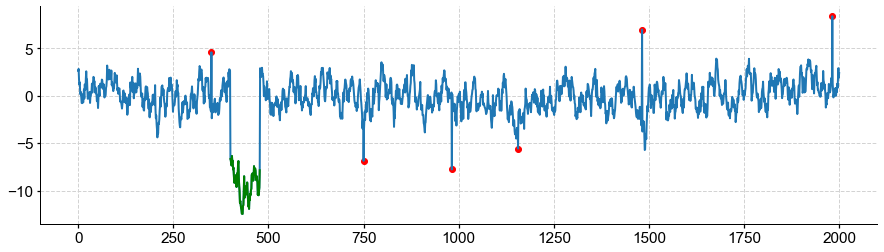

In [45]:
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
# Add outliers
out_indices = [350, 1482, 1982, 1156, 750, 982]
outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))
out_vals=outlier_values[[2,26,40,56,69,78]]
time_out = time[out_indices]
    
signal_out = np.copy(noisy_sig)
for idx,item in enumerate(out_indices):
    signal_out[item] = out_vals[idx]

signal_shift=np.copy(signal_out)
signal_shift[400:478]=signal_out[400:478]-10

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_shift)
plt.scatter(time_out,signal_shift[out_indices],color='r')
plt.plot(time[400:478],signal_shift[400:478],color='g')

In [41]:
def create_shift_signal(shift_value=3):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)

    # Add colored noise

    t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
    noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
    # Add outliers
    out_indices = [350, 1482, 1982, 1156, 750, 982]
    outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
    outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
    vals = np.arange(outliers_start,outliers_end,0.1)
    outlier_values=np.concatenate((vals,-vals))
    out_vals=outlier_values[[2,26,40,56,69,78]]
    time_out = time[out_indices]
    
    signal_out = np.copy(noisy_sig)
    for idx,item in enumerate(out_indices):
        signal_out[item] = out_vals[idx]

    signal_shift=np.copy(signal_out)
    signal_shift[400:478]=signal_out[400:478]+shift_value
    
    return time,signal_shift

In [43]:
# Initialize the sweep

method=['DBSCAN', 'kmeans']
out_indices = [350, 1482, 1982, 1156, 750, 982]
shift_value_list = [-10,-7,-5,5,7,10]

method_list=[]
shift_list = []
out_truth=[]
out_inferred = []
correct = [] 
false_positive =[]
missed =[]

In [44]:
%%time
for m in method:
    for shift_value in shift_value_list:
        method_list.append(m)
        shift_list.append(shift_value) 
        out_truth.append(out_indices)
        time,value = create_shift_signal(shift_value)
        if m == 'DBSCAN':
            idx, res = detect_outliers_DBSCAN(value)
        else:
            idx, res = detect_outliers_kmeans(value)
        out_inferred.append(idx)
        correct.append(len(set(list(idx)).intersection(list(out_indices))))
        false_positive.append(len(idx)-len(set(list(idx)).intersection(list(out_indices))))
        missed.append(len(list(out_indices))-len(set(list(idx)).intersection(list(out_indices))))

Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 9min 55s, sys: 1min 23s, total: 11min 19s
Wall time: 10min 35s


In [46]:
df = pd.DataFrame({'Method': method_list,
                   'Shift values': shift_list,
                   'Indices of added outliers': out_truth,
                   'Indices of identified outliers': out_inferred,
                   'Number of Correctly Identified outliers': correct,
                   'Number of false positive': false_positive,
                   'Number of false negative': missed
                  })

df

,Method,Shift values,Indices of added outliers,Indices of identified outliers,Number of Correctly Identified outliers,Number of false positive,Number of false negative
0,DBSCAN,-10,"[350, 1482, 1982, 1156, 750, 982]","[400, 401, 402, 403, 404, 405, 406, 407, 408, ...",1,78,5
1,DBSCAN,-7,"[350, 1482, 1982, 1156, 750, 982]","[400, 401, 402, 403, 404, 405, 406, 407, 408, ...",4,64,2
2,DBSCAN,-5,"[350, 1482, 1982, 1156, 750, 982]","[404, 982]",1,1,5
3,DBSCAN,5,"[350, 1482, 1982, 1156, 750, 982]",[1982],1,0,5
4,DBSCAN,7,"[350, 1482, 1982, 1156, 750, 982]","[430, 431, 432, 1982]",1,3,5
5,DBSCAN,10,"[350, 1482, 1982, 1156, 750, 982]","[402, 403, 407, 408, 409, 410, 411, 412, 413, ...",2,72,4
6,kmeans,-10,"[350, 1482, 1982, 1156, 750, 982]",[982],1,0,5
7,kmeans,-7,"[350, 1482, 1982, 1156, 750, 982]","[750, 982]",2,0,4
8,kmeans,-5,"[350, 1482, 1982, 1156, 750, 982]","[750, 982]",2,0,4
9,kmeans,5,"[350, 1482, 1982, 1156, 750, 982]","[428, 429, 430, 431, 432, 449, 750, 982, 1482,...",4,6,2


 Plot these:

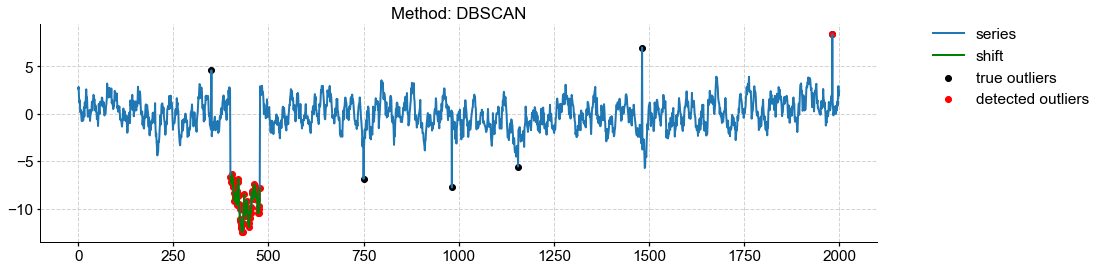

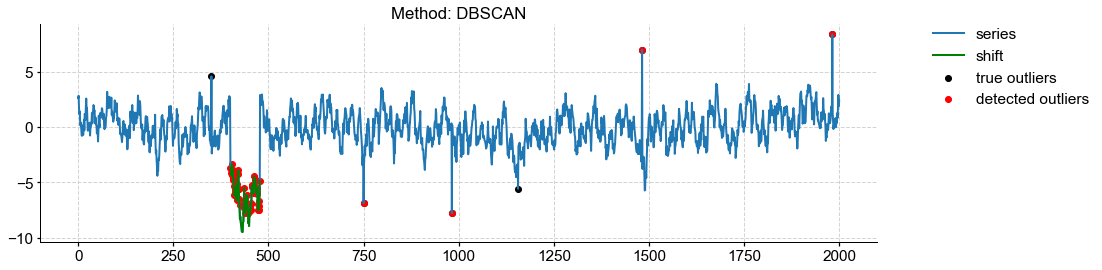

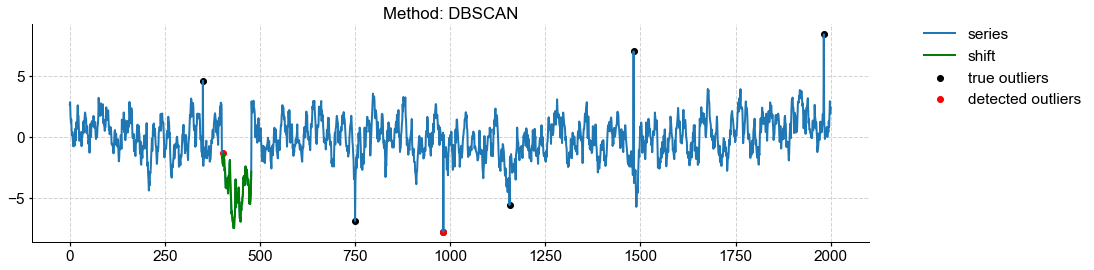

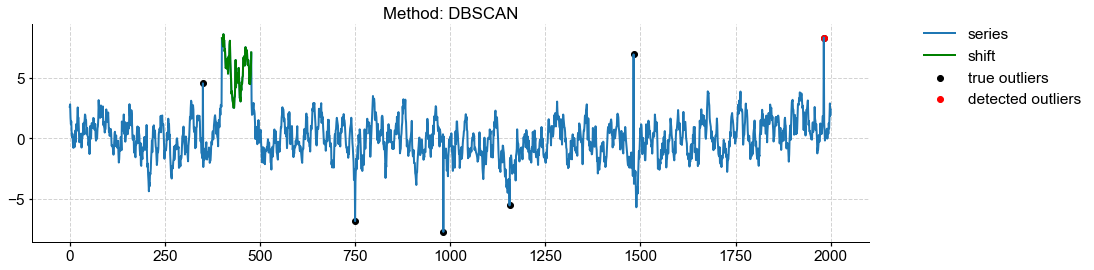

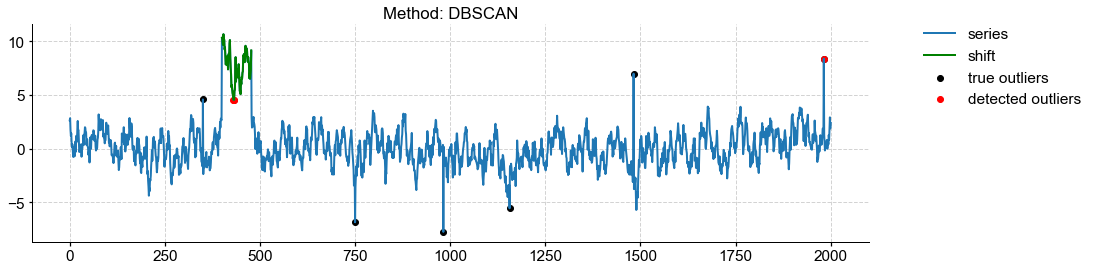

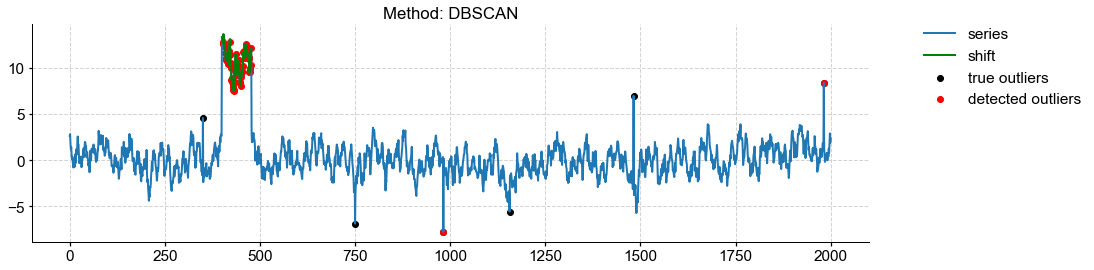

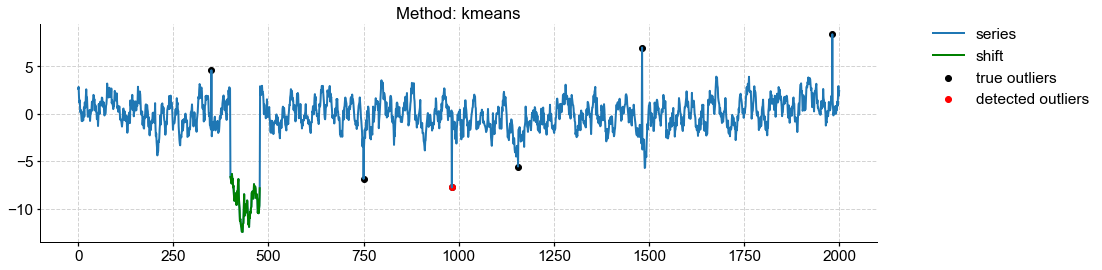

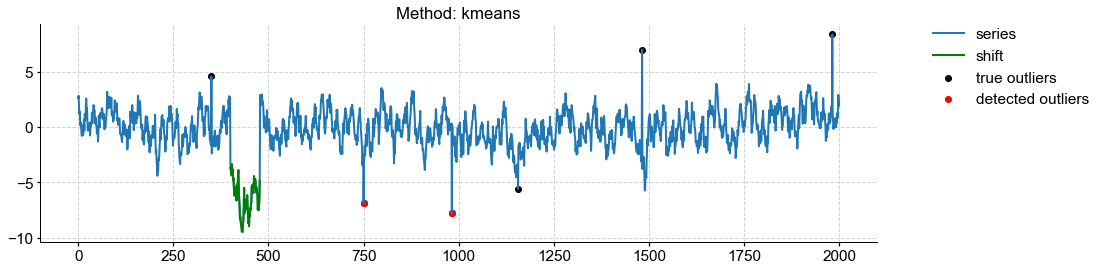

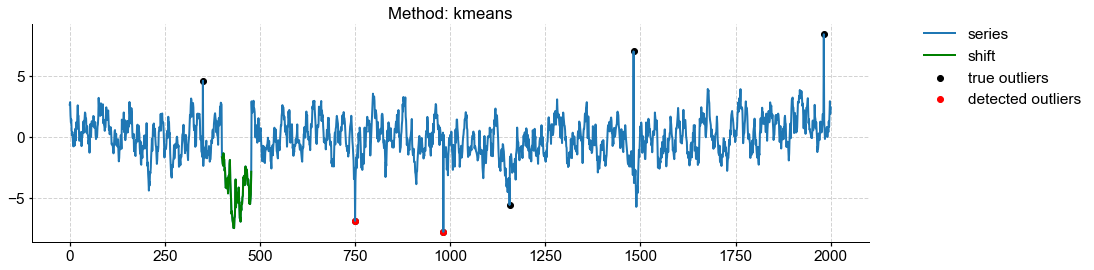

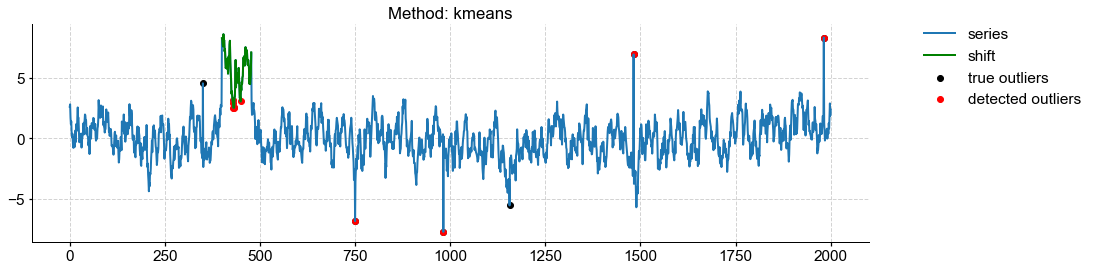

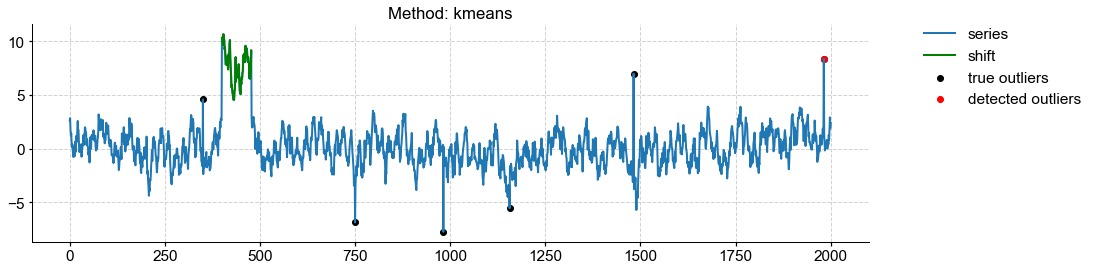

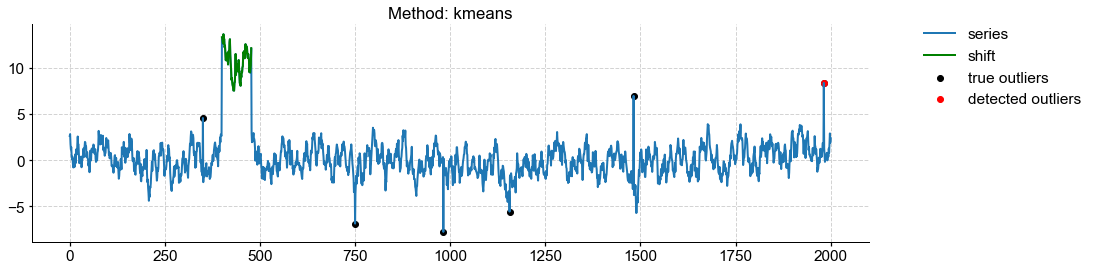

In [54]:
for idx,row in df.iterrows():

    signal_shift[400:478]=signal_out[400:478]+row['Shift values']
    fig=plt.figure(figsize=(15,4))
    plt.plot(time,signal_shift,label='series')
    plt.plot(time[400:478],signal_shift[400:478],color='g',label='shift')
    plt.scatter(time[row['Indices of added outliers']],signal_shift[row['Indices of added outliers']],color='k',label='true outliers')
    plt.scatter(time[row['Indices of identified outliers']],signal_shift[row['Indices of identified outliers']],color='r',label='detected outliers')
    plt.title('Method: ' + row['Method'])
    plt.legend(bbox_to_anchor=(1.05, 1.05))
    plt.show()